In [1]:
import os 
import numpy as np 
import pickle
from tqdm import tqdm 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import copy


from sklearn.utils import resample, shuffle
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import PredefinedSplit
from scipy.optimize import curve_fit


In [13]:
# functions 
###### helper functions ####### 
def pkl_read(file_to_read, write_dir):
  os.chdir(write_dir)
  this = pickle.load(open(file_to_read, "rb"))
  # print(this)
  return this

def pkl_write(file_to_write, values_to_dump, write_dir):
  os.chdir(write_dir)
  with open(file_to_write, 'wb') as pickle_file:
      pickle.dump(values_to_dump, pickle_file)

def getdata_day(data,id,data_day):
  if id == 1:
    # var_name = data[0:data_day[id]+1,:,:]
    var_name = data[0:data_day[id],:,:]
  else:
    day_idx = np.where(np.array(list(data_day))== id)[0].astype(int) - 1
    #print(day_idx[0])
    prev_day_id = list(data_day)[day_idx[0]]
    #print(prev_day_id)
    var_name = data[data_day[prev_day_id]:data_day[id],:,:]
  return var_name

def gettarget_day(target_direction, id, day):
    if id == 1: 
      target = target_direction[:day[id]]
    else:
      day_idx = np.where(np.array(list(day))== id)[0].astype(int) - 1
      #print(day_idx[0])
      prev_day_id = list(day)[day_idx[0]]
      target = target_direction[day[prev_day_id]:day[id]] 
    return target

def get_numtrials_perday(datasize_day):
    '''
    datasize_day: dictionary with key as day and value as end trial index for that day . Comes from getdata_day()
    '''
    num_trials_perday = np.zeros(len(datasize_day))
    num_trials_perday[0] = np.array(list(datasize_day.values()))[0]
    num_trials_perday[1:] = np.diff(np.array(list(datasize_day.values())))
    # print(num_trials_perday)
    return num_trials_perday

def trial_concatenate_data(data):
    '''
    data is on shape n_trials x n_units x n_bins 
    '''
    n,u,t = data.shape
    new_arr = np.transpose(data, (0,2,1))
    new_arr = new_arr.reshape(n*t, u)
    # print(new_arr.shape)
    return new_arr 

###### LR analysis functions #########

def get_equal_target_dist_predefinedsplit(idx, target, n_samples_per_target):
  random_idx = []
  for it in range(8):
    this_idx = np.where(target== it+1)
    
    r_idx = np.random.choice(this_idx[0], n_samples_per_target, replace = False)
    # print(r_idx)
    random_idx.append(r_idx)
  # print(np.shape(random_idx))
  rand_idx = np.array(random_idx).reshape(n_samples_per_target*8)
  ps = np.zeros(len(target))
  ps[rand_idx] = -1 # index for training 
  # ps[ps == 0] = 1 # index for test set

  # to genereate 2 fold cross validation
  test_idx = np.argwhere(~np.in1d(np.arange(len(ps)), rand_idx))
  first_fold = test_idx[:len(test_idx)//2]
  second_fold = test_idx[len(test_idx)//2:]
  ps[first_fold] = 0   # index for test set for fold 1
  ps[second_fold] = 1 # index for test set for fold 2
  print(ps[ps == -1].shape, ps[ps == 0].shape, ps[ps == 1].shape)
  return ps

def flatten_data(data):
    # Flattens the last two dimensions of the data
    return data.reshape(data.shape[0], -1)


def matrix_similarity(A, B):
    """
    Compute the R^2 similarity between two matrices by treating them as vectors.

    Args:
    - A: First 2D matrix.
    - B: Second 2D matrix.

    Returns:
    - R^2 value representing the similarity between the matrices.
    """
    assert A.shape == B.shape, "Matrices must have the same shape"

    # Flatten the matrices to vectors
    A_flat = A.ravel()
    B_flat = B.ravel()

    # Compute the correlation coefficient
    correlation_matrix = np.corrcoef(A_flat, B_flat)
    r = correlation_matrix[0, 1]
    
    # Square the correlation coefficient to get R^2 value
    r2 = r #**2
    return r2



In [24]:
neural_recordings = pkl_read('neural_data.pkl', '.') # Shape: n_tr x n_units x n_timebins; top 16 units are readouts 
target_direction = pkl_read('target_labels.pkl', '.')
datasize_day = pkl_read('trial_day_label.pkl', '.')

days = [2,3,4,5,6,7] # just for example. In the paper, we considered all days that had a minimum of 25 trials of successful reaches per target direction, minimum 200 trials in total.  
n_readouts = 20
decoder_change_days = [0,0,0,0,0,1]
unit_swap_day = [0,0,0,0,0,0]

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def run_logistic_model_acrossdays(neural_recordings, target_direction, days_wtrials, n_bs, label = 'readout'):
    n_target = 8 
    n_days_wtrials = len(days)
    n_neurons = neural_recordings.shape[1]
    n_timebins = neural_recordings.shape[2]
    dec_change = np.in1d(days, decoder_change_days)
    unit_swap = np.in1d(days, unit_swap_day)

    # store analysis results
    accu = pd.DataFrame()

    coef_norm = np.zeros((n_bs, n_days_wtrials))
    delta_coef = np.zeros((n_bs, n_neurons))
    r2_coef = np.zeros((n_bs, n_days_wtrials))

    # try:
    # per draw 
    for idraw in tqdm(range(n_bs)): 
            
        accuracy_draw = np.zeros(n_days_wtrials) 
        coef_draw = np.zeros((n_days_wtrials, n_target, n_neurons * n_timebins ))

        for id, iday in tqdm(enumerate(days)): 
            # per day
            data = getdata_day(neural_recordings,iday, datasize_day )
            target = gettarget_day(target_direction, iday, datasize_day)
            # print(np.unique(target))
    
            data_flat = flatten_data(data) # Concatenating the third dimension trials x neurons x time --> trials x (neuron *time)

            # Trial selection to maintain same size of data each day 
            idx = np.arange(0,len(data),1)
            test_fold = get_equal_target_dist_predefinedsplit(idx,target, 25) # function that returns 200 random trials ids with equal distribution of target directions in the dataset 
            ps = PredefinedSplit(test_fold)

            # Initializing a linear model 
            # Logistic Regression Model
            my_model = linear_model.LogisticRegression(penalty = 'l2', max_iter=1000, C = 1)

        
            # Creating a pipeline
            pipe = Pipeline([
                ('scale', StandardScaler()), 
                ('logistic', my_model)
            ]) 
            #cross validate coef
            cv_results = model_selection.cross_validate(pipe, data_flat, target, cv= ps, return_estimator=True)
            # accuracy_draw[id] = cv_results['test_score']
            accuracy_draw[id] = np.mean(cv_results['test_score'])
            
            # Iterating over the estimators to access the logistic regression coefficients
            for idx, estimator in enumerate(cv_results['estimator']):
                coef_draw[id,:,:] = estimator.named_steps['logistic'].coef_
                if id > 0:
                    r2_coef[idraw,id] =  matrix_similarity(coef_draw[id,:,:], coef_draw[id-1,:,:])

        accu = pd.concat([accu, pd.DataFrame({'prediction accuracy': accuracy_draw,'day':days,'label': label, 'decoder_change':dec_change, 'unit_swap': unit_swap })], ignore_index=True) 

    return accu, r2_coef 


In [26]:
label = 'all'
n_bs = 5
accu_all,r2_coef = run_logistic_model_acrossdays(neural_recordings, target_direction, datasize_day, n_bs, label = 'all')

neural_recordings_readout = neural_recordings[:,:n_readouts, :]
print(neural_recordings_readout.shape)
accu_r, r2_r = run_logistic_model_acrossdays(neural_recordings_readout, target_direction, datasize_day, n_bs, label = 'readout')

neural_recordings_nonreadout = neural_recordings[:,n_readouts:, :]
print(neural_recordings_nonreadout.shape)
accu_nr, r2_nr = run_logistic_model_acrossdays(neural_recordings_nonreadout, target_direction, datasize_day, n_bs, label = 'nonreadout')

## Concatenate and save prediction accuracy across days for all three neural populations 
accu = pd.concat([accu_all, accu_r, accu_nr], ignore_index = True)
display(accu)



  0%|          | 0/5 [00:00<?, ?it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)
(200,) (261,) (262,)


6it [00:00, 16.81it/s]
 20%|██        | 1/5 [00:00<00:01,  2.78it/s]

(200,) (59,) (60,)
(200,) (437,) (437,)


(200,) (238,) (238,)
(200,) (199,) (200,)


(200,) (409,) (410,)
(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 17.15it/s]
 40%|████      | 2/5 [00:00<00:01,  2.81it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)


(200,) (409,) (410,)
(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 16.82it/s]
 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)


(200,) (409,) (410,)
(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 18.71it/s]
 80%|████████  | 4/5 [00:01<00:00,  2.91it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)
(200,) (261,) (262,)


(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 15.46it/s]
100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


(12730, 20, 18)


  0%|          | 0/5 [00:00<?, ?it/s]

(200,) (238,) (238,)


(200,) (199,) (200,)
(200,) (409,) (410,)
(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 23.36it/s]
 20%|██        | 1/5 [00:00<00:01,  3.86it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)
(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 26.74it/s]
 40%|████      | 2/5 [00:00<00:00,  4.16it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)


6it [00:00, 24.23it/s]
 60%|██████    | 3/5 [00:00<00:00,  4.08it/s]

(200,) (437,) (437,)


(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 24.67it/s]
 80%|████████  | 4/5 [00:00<00:00,  4.07it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 26.46it/s]
100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


(12730, 35, 18)


  0%|          | 0/5 [00:00<?, ?it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)


(200,) (409,) (410,)
(200,) (261,) (262,)


(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 18.67it/s]
 20%|██        | 1/5 [00:00<00:01,  3.09it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)


6it [00:00, 20.50it/s]
 40%|████      | 2/5 [00:00<00:00,  3.25it/s]

(200,) (437,) (437,)


(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 19.52it/s]
 60%|██████    | 3/5 [00:00<00:00,  3.24it/s]

(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)


6it [00:00, 23.72it/s]
 80%|████████  | 4/5 [00:01<00:00,  3.47it/s]

(200,) (437,) (437,)


(200,) (238,) (238,)
(200,) (199,) (200,)
(200,) (409,) (410,)


(200,) (261,) (262,)
(200,) (59,) (60,)
(200,) (437,) (437,)


6it [00:00, 19.70it/s]
100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


,prediction accuracy,day,label,decoder_change,unit_swap
0,0.760504,2,all,False,False
1,0.744397,3,all,False,False
2,0.776570,4,all,False,False
3,0.774341,5,all,False,False
4,0.772881,6,all,False,False
...,...,...,...,...,...
85,0.506307,3,nonreadout,False,False
86,0.590933,4,nonreadout,False,False
87,0.550620,5,nonreadout,False,False
88,0.596469,6,nonreadout,False,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: unsupported operand type(s) for -: 'list' and 'int'

<Figure size 900x600 with 0 Axes>

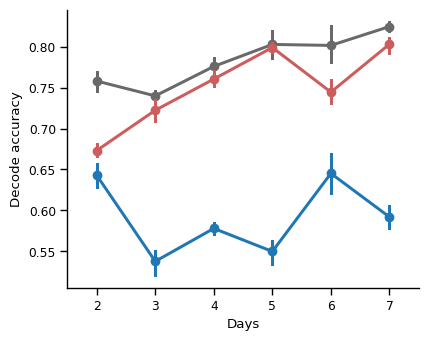

In [28]:
# accu = pd.read_csv(df_name)
sns.set_context('paper')
plt.figure(figsize = (3,2), dpi = 300)
g = sns.catplot(data = accu, x='day',y = 'prediction accuracy', errorbar='ci', hue = 'label', kind = 'point',legend= False,  legend_out = False, height = 3.5, aspect = 3.5/2.8, palette=sns.color_palette(['dimgrey', 'indianred', 'tab:blue']))
plt.ylabel('Decode accuracy')
plt.xlabel('Days')
plt.legend(frameon=False, loc= 'lower left', labelcolor = 'linecolor')